In [1]:
import gym
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense
from keras.optimizers import Adam
from tqdm import tqdm

Using TensorFlow backend.
/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/david.bertoin/anaconda3/envs/IRT_RL2/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Agent

In [2]:
class Agent():
    
    def __init__(self, state_size, action_size, weights=None):
        
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.gamma = 0.95
        self.model = self.build_model()
        if weights != None:
            self.model.load_weights(weights)
        
    def build_model(self, layer_size=24, learning_rate=0.003):
        model = Sequential()
        model.add(Dense(layer_size, input_dim=self.state_size, activation='relu'))
        model.add(Dense(layer_size, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(learning_rate))
        
        return model
        
    def next_action(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        actions = self.model.predict(state)[0]
        return np.argmax(actions)
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
                return
        sample_batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = self.model.predict(state)
            if not done:
                target[0][action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            else:
                target[0][action] = reward
            self.model.fit(state, target, epochs=1, verbose=0)

        self.exploration_rate = max(self.exploration_min, self.exploration_rate * self.exploration_decay)
    
    def learn(self, env, nb_episodes, max_step_by_episode=200, batch_size=32):
        scores = []
        pbar = tqdm(range(nb_episodes))
        for i in pbar:
            state = np.reshape(env.reset(), [1, self.state_size])
            nb_steps_this_episode = 0
            done = False
            while not done:
                action = self.next_action(state)
                next_state, reward, done, _ = env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.remember(state, action, reward, next_state, done)
                nb_steps_this_episode += 1
                if done:
                    break
                state = next_state
            pbar.set_description("episode: %s, nb_steps_this_episode: %s" % (i, nb_steps_this_episode))
            scores.append(nb_steps_this_episode)
            self.replay(batch_size)
        return scores
     

# Environnement

In [3]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


# Training

episode: 499, nb_steps_this_episode: 136: 100%|██████████| 500/500 [05:23<00:00,  1.54it/s]


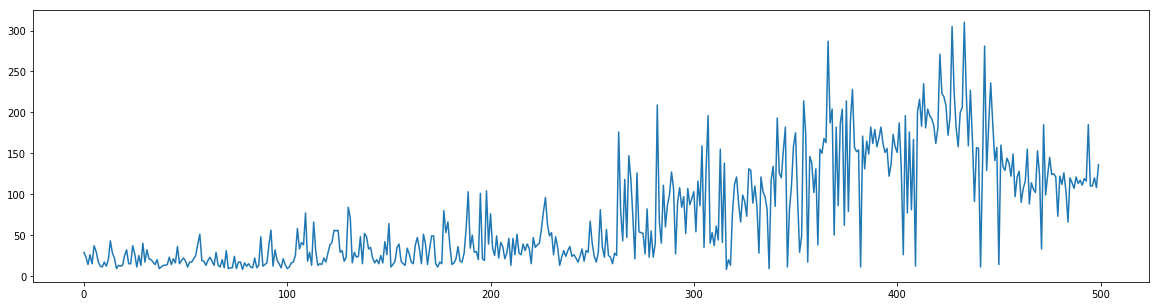

In [4]:
scores = agent.learn(env, 500)
plt.figure(figsize=(20,5))
plt.plot(scores)

# Playing

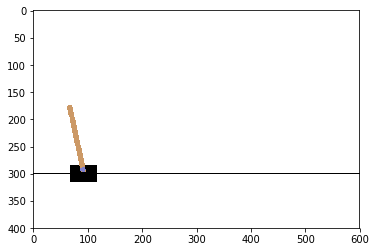

In [7]:
from distant_gym_render import distant_render
distant_render(env, agent, state_size)

# Save weights

In [6]:
agent.model.save_weights("./weights/dqn_cartpole.h5")